# Lab 4 Neural Networks
* Nicholas Larsen
* Steven Larsen

In this lab we will explore different kinds of Neural Networks starting with a simple 2 layer Perceptron and ending up with a 5 Layer Perceptron with different kinds of preprocessing and 2 different adaptive learning techniques.

The dataset description can be found here:https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

# Load Split and Balance

## Load into Pandas

In [4]:
import numpy as np
import pandas as pd
import missingno as mn
from sklearn.datasets import load_digits



ds = load_digits()
X_nums = ds.data/16.0-0.5 # normalize the input, very important
y_nums = ds.target

df = pd.read_csv('./../acs2017_census_tract_data.csv')
df

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,72153750501,Puerto Rico,Yauco Municipio,6011,3035,2976,99.7,0.3,0.0,0.0,...,0.5,0.0,3.6,26.9,1576,59.2,33.8,7.0,0.0,20.8
73997,72153750502,Puerto Rico,Yauco Municipio,2342,959,1383,99.1,0.9,0.0,0.0,...,0.0,0.0,1.3,25.3,666,58.4,35.4,6.2,0.0,26.3
73998,72153750503,Puerto Rico,Yauco Municipio,2218,1001,1217,99.5,0.2,0.0,0.0,...,3.4,0.0,3.4,23.5,560,57.5,34.5,8.0,0.0,23.0
73999,72153750601,Puerto Rico,Yauco Municipio,4380,1964,2416,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5


<AxesSubplot:>

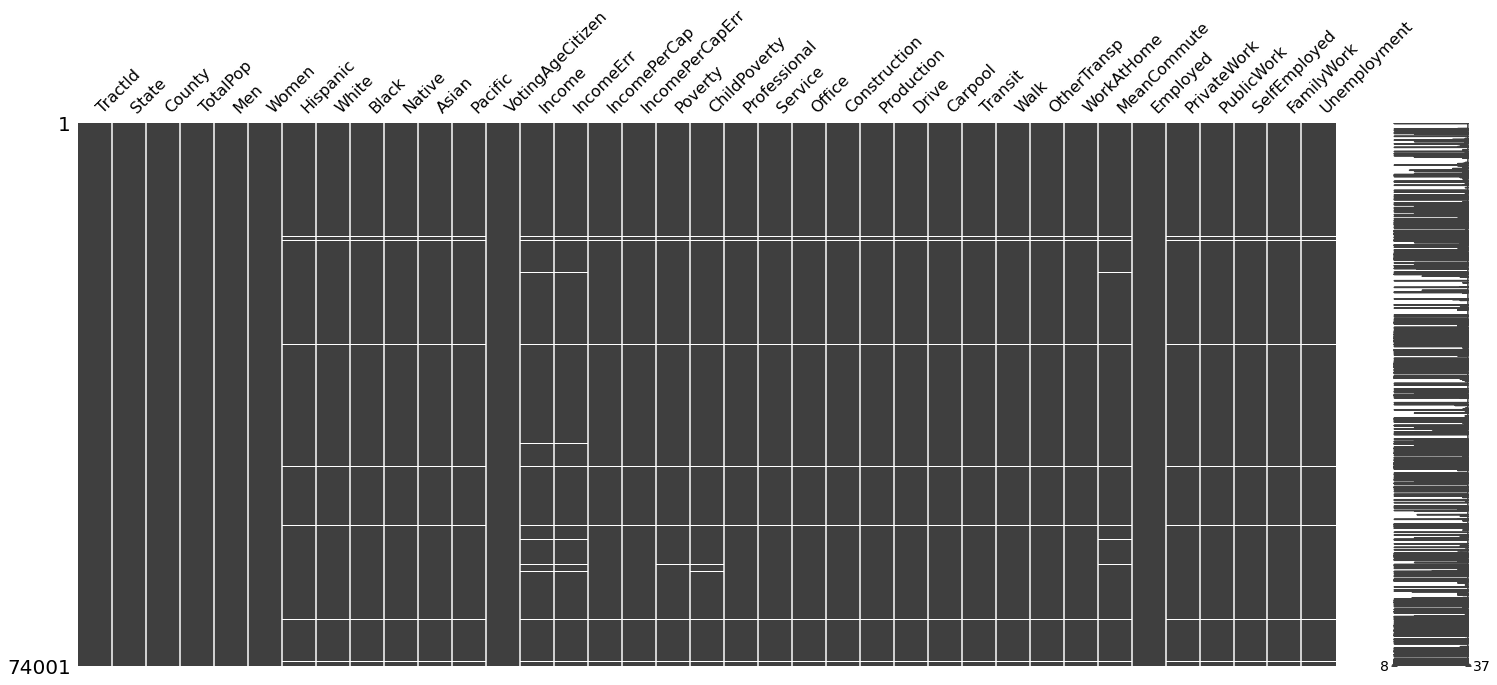

In [5]:
mn.matrix(df)

Based on this we are going to do some data clean up.  There are quite a few white lines across that data.  That represents records with large amounts of missing data across multiple features.  For those records we will throw them out. Firstly we will see the impacts of throwing out all records with at least one missing feature.

<AxesSubplot:>

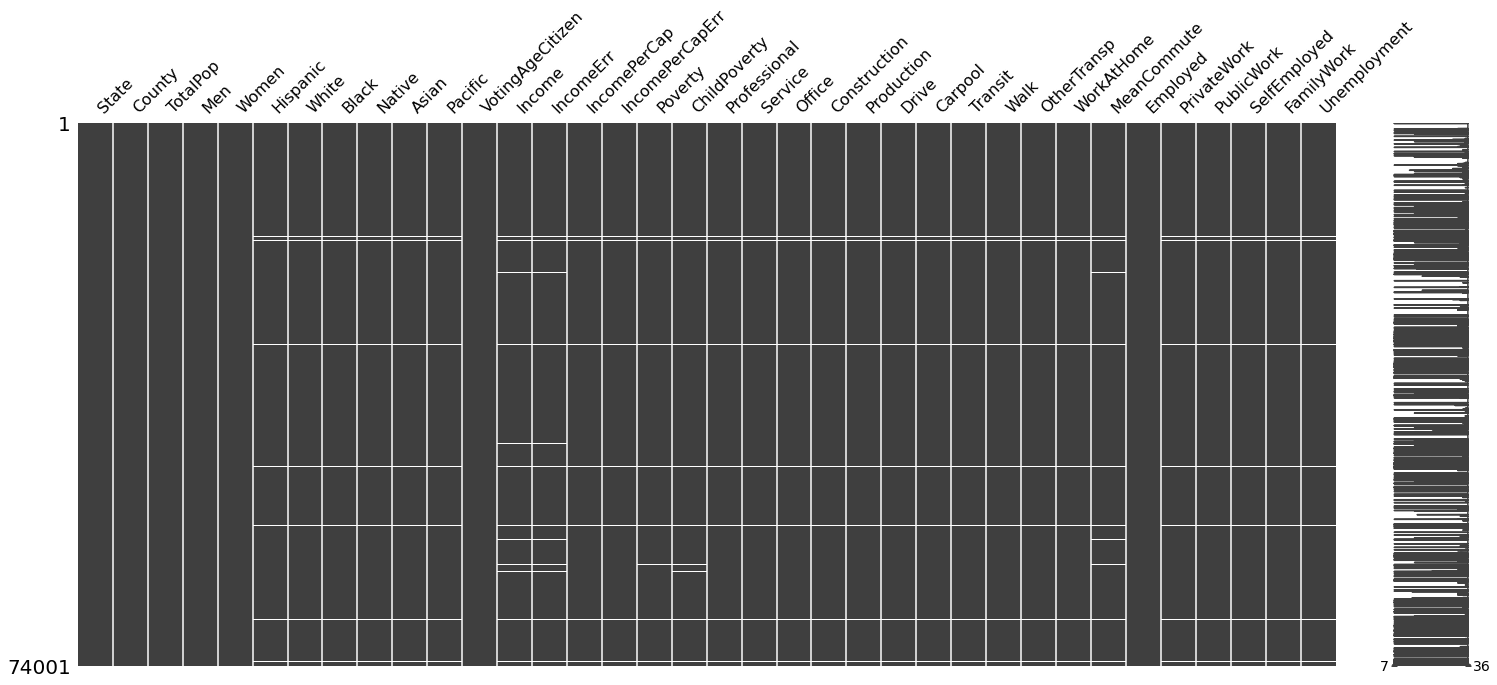

In [6]:
df = df.drop(columns='TractId')
mn.matrix(df)

<AxesSubplot:>

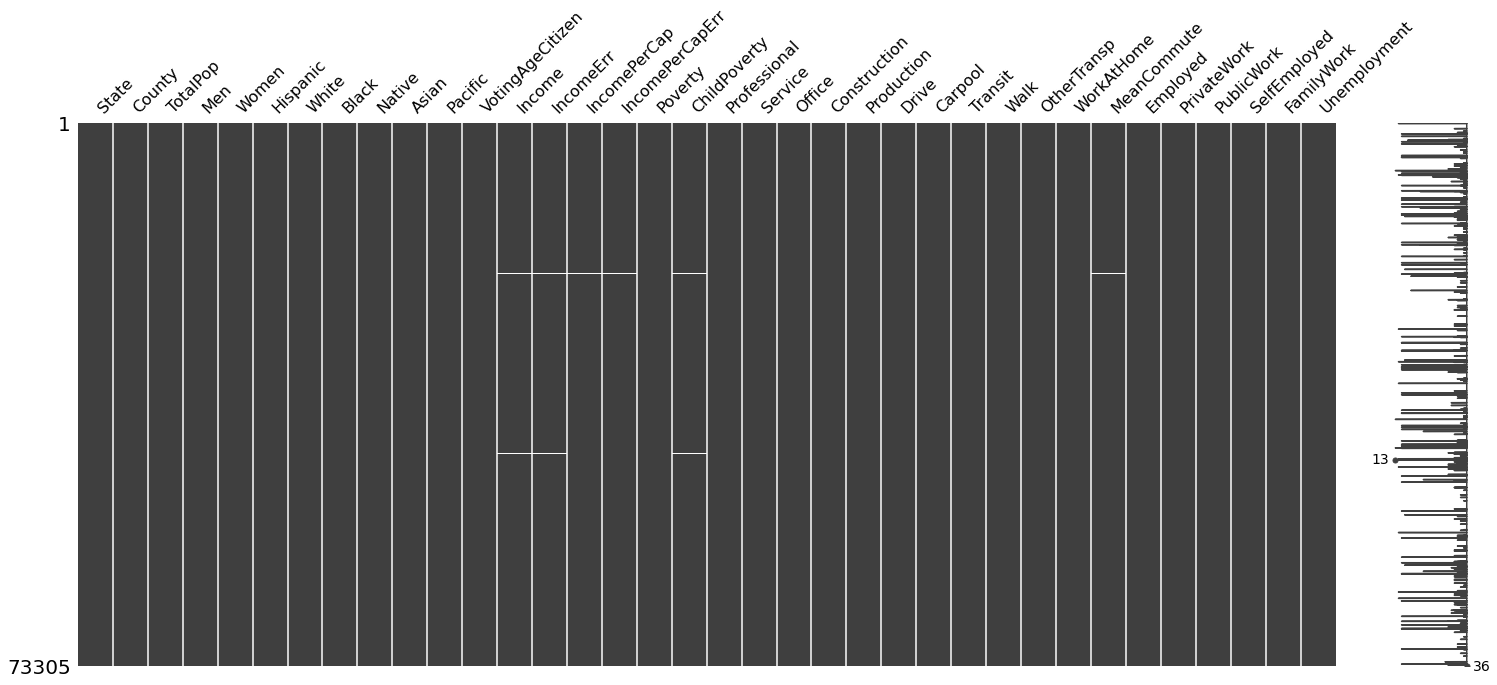

In [7]:
from numpy import nan
df = df[df.Hispanic.notnull()]
mn.matrix(df)

<AxesSubplot:>

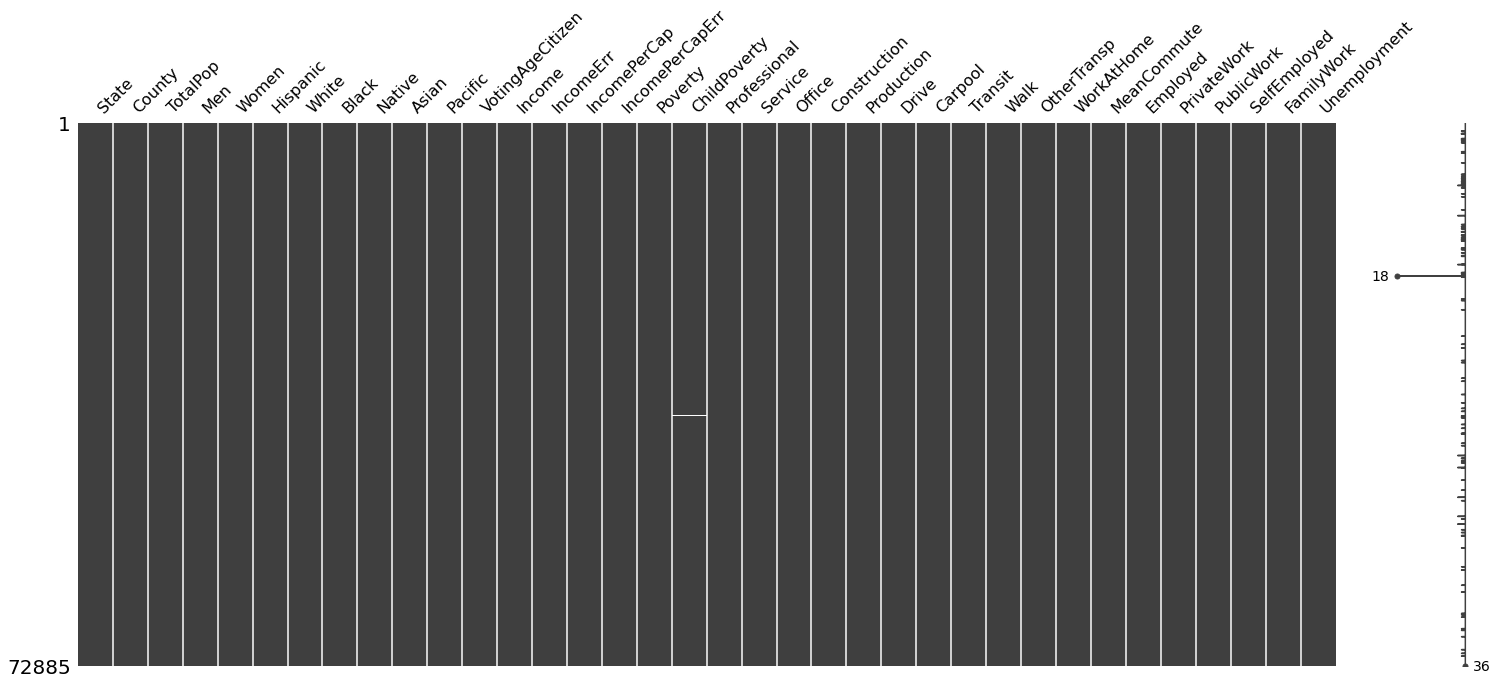

In [8]:
df = df[df.Income.notnull()]
mn.matrix(df)

<AxesSubplot:>

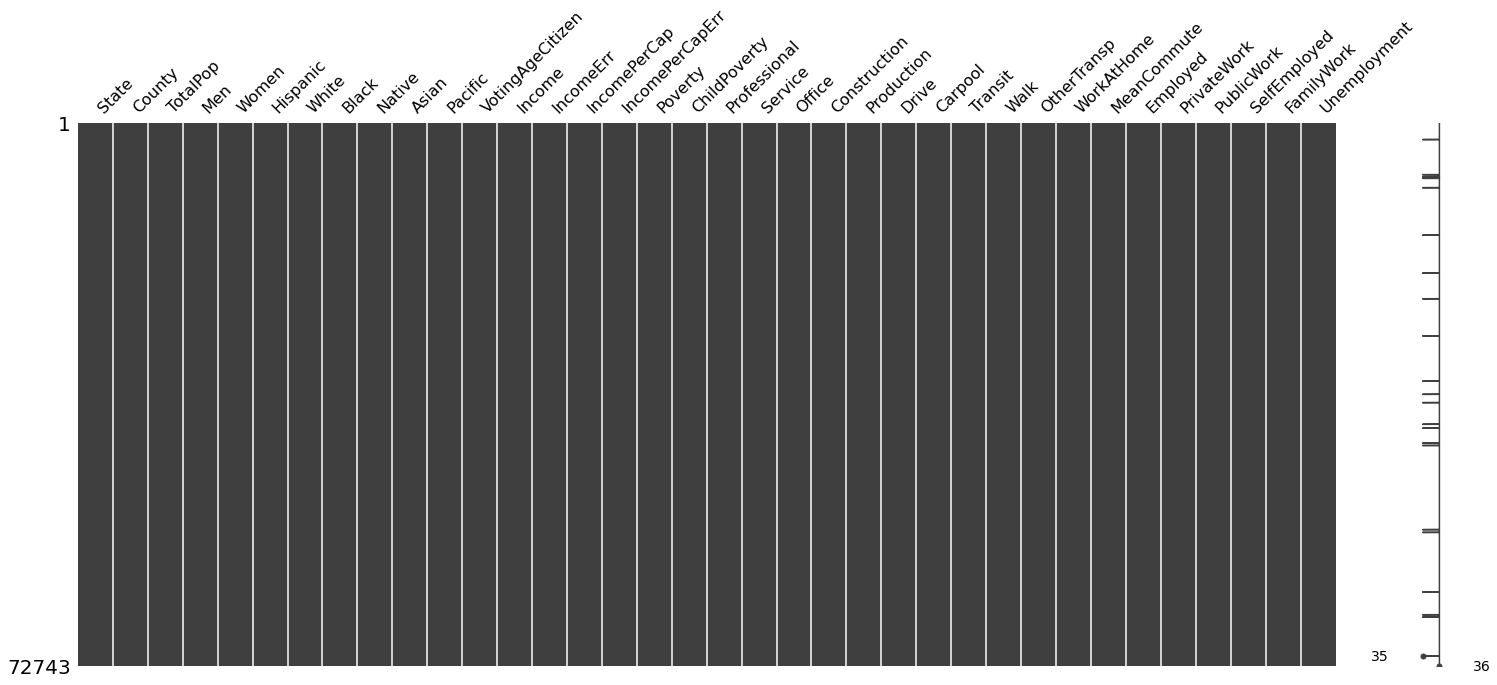

In [9]:
df = df[df.ChildPoverty.notnull()]
mn.matrix(df)

<AxesSubplot:>

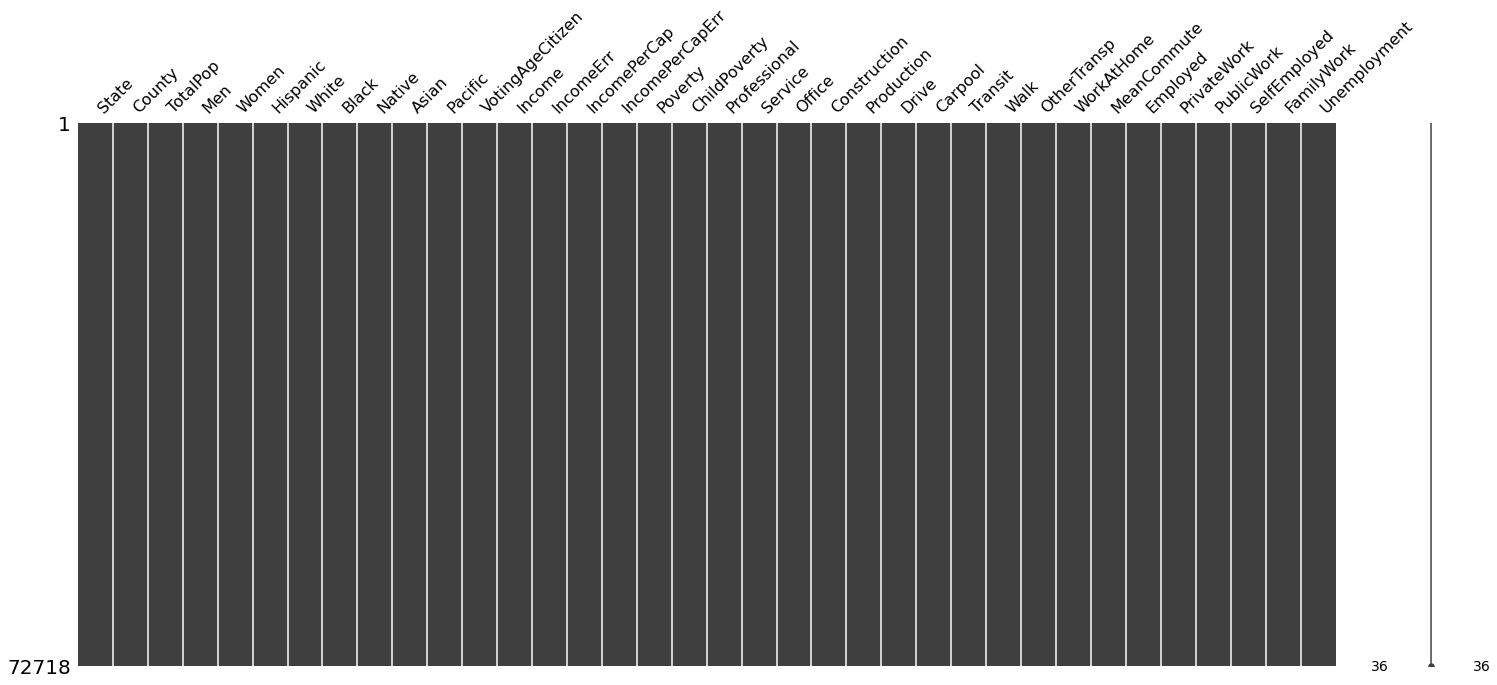

In [10]:
df = df[df.MeanCommute.notnull()]
mn.matrix(df)

In [11]:
for col in df.columns:
    print(len(df[df[col].isnull()]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


We are happy with throwing these records out, because they are such a small portion of the data and without them the data is fairly complete.

## Balance the data

Balaning will take place before the train test split. That way the classes are defined the same for both, if the class lines were defined after the train test split the four class lines may be different

In [12]:
df['ChildPoverty'].describe()

count    72718.000000
mean        21.148476
std         18.572714
min          0.000000
25%          6.200000
50%         16.300000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64

In [13]:
labels = ['low', 'med-low', 'med-high', 'high']
df['child_poverty_class'] = pd.qcut(df['ChildPoverty'],
                             q=4,
                             labels=labels)
df['child_poverty_class'].describe()

count     72718
unique        4
top         low
freq      18229
Name: child_poverty_class, dtype: object

In [14]:
df['child_poverty_class'].value_counts()

low         18229
med-low     18171
high        18170
med-high    18148
Name: child_poverty_class, dtype: int64

<AxesSubplot:>

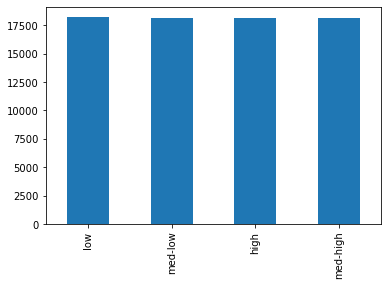

In [15]:
df['child_poverty_class'].value_counts().plot(kind='bar')

## Split the data

Size of X Train 58174
Size of X Test 14544
Size of y Train 58174
Size of y Test 14544


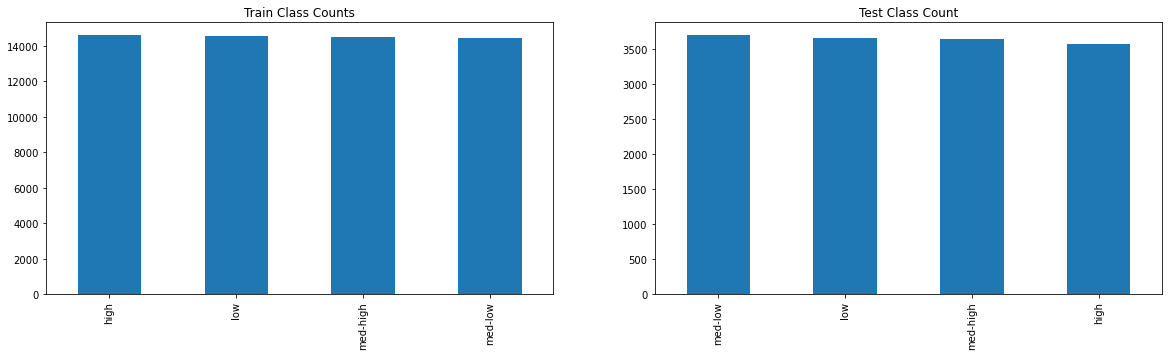

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df_y = df['child_poverty_class']

X_train_df, X_test_df, y_train_df, y_test_df = \
    train_test_split(df, df_y, test_size=0.2)
print('Size of X Train', len(X_train_df))
print('Size of X Test', len(X_test_df))
print('Size of y Train', len(y_train_df))
print('Size of y Test', len(y_test_df))

fig = plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
X_train_df['child_poverty_class'].value_counts().plot(kind='bar')
plt.title('Train Class Counts')
plt.subplot(1,2,2)
X_test_df['child_poverty_class'].value_counts().plot(kind='bar')
plt.title('Test Class Count')

X_train_df = X_train_df.drop(columns=['child_poverty_class','ChildPoverty'])

X_test_df = X_test_df.drop(columns=['child_poverty_class','ChildPoverty'])

# Pre-processing

## 2 Layer Perceptron 

In [89]:
#Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
#Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1,random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.minibatches = minibatches
        self.shuffle = shuffle
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [101]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        
        #print( grad1, grad2)
        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        # get starting acc
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [102]:
code_classes = {"child_poverty_class": {'low':0, 'med-low':1, 'med-high':2, 'high':3}}
X_train = X_train_df.drop(columns=['State','County']).to_numpy()
y_train = y_train_df.to_frame().replace(code_classes).to_numpy().ravel()

X_test = X_test_df.drop(columns=['State','County']).to_numpy()
y_test = y_test_df.to_frame().replace(code_classes).to_numpy().ravel()

print(X_train.shape)
print(y_train)
print(X_test.shape)
print(y_test.shape)

(58174, 33)
[3 1 0 ... 0 1 0]
(14544, 33)
(14544,)


In [ ]:
%%time 
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

params = { 'n_hidden':30, 
         'C':0.1, 'epochs':500, 'eta':0.1, 
         'alpha':0.01, 'decrease_const':1e-5, 'minibatches':15,
         'shuffle':True,'random_state':1}



#X_train, X_test, y_train, y_test = train_test_split(X_nums,y_nums,test_size = 0.2)

nn = TwoLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10,XY_test=(X_test,y_test))
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))

Epoch: 250/500

In [ ]:
print(min(y_test),max(y_test))
print(min(yhat),max(yhat))
print(min(y_train),max(y_train))

### Graph Loss

In [ ]:
def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
print_result(nn,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")

plt.show()

## 2 Layer Perceptron with Normalize 

In [81]:
from sklearn.preprocessing import normalize
X_train = X_train_df.drop(columns=['State','County'])
X_test = X_test_df.drop(columns=['State','County'])
X_train_df_norm = X_train.copy()
X_test_df_norm = X_test.copy()

# Force the sum to be 1 of all of the features
for col in X_train.columns:
    X_train_df_norm[col] = X_train[col] / np.linalg.norm(X_train[col])
    X_test_df_norm[col] = X_test[col] / np.linalg.norm(X_train[col])
X_train_df_norm.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
35077,0.002471,0.002028,0.002885,0.000000,0.000000,0.016343,0.0,0.000000,0.000000,0.002759,...,0.000823,0.003181,0.007829,0.005482,0.001360,0.004129,0.002796,0.005563,0.0,0.013401
20515,0.008199,0.008407,0.007948,0.000891,0.000254,0.000033,0.0,0.029732,0.040122,0.007725,...,0.001715,0.006759,0.001258,0.005359,0.008427,0.004202,0.004024,0.002065,0.0,0.001687
18180,0.033671,0.031590,0.035485,0.000273,0.005811,0.000131,0.0,0.000285,0.000409,0.046828,...,0.000686,0.015108,0.013002,0.003547,0.009181,0.004134,0.003005,0.005047,0.0,0.001827
46817,0.003456,0.003116,0.003765,0.001925,0.002842,0.000703,0.0,0.013459,0.000000,0.003431,...,0.002881,0.000000,0.002167,0.007155,0.004297,0.004103,0.004730,0.001606,0.0,0.000890
64009,0.001975,0.002069,0.001872,0.012269,0.000883,0.000000,0.0,0.000000,0.000000,0.001266,...,0.000000,0.000000,0.000000,0.003808,0.001885,0.004430,0.000601,0.007054,0.0,0.001968


In [82]:

code_classes = {"child_poverty_class": {'low':0, 'med-low':1, 'med-high':2, 'high':3}}
X_train = X_train_df_norm.to_numpy()
y_train = y_train_df.to_frame().replace(code_classes).to_numpy().ravel()
X_test = X_test_df_norm.to_numpy()
y_test = y_test_df.to_frame().replace(code_classes).to_numpy().ravel()


X_train_df_norm.head()
print(X_train.shape)
print(y_train)
print(X_test.shape)
print(y_test.shape)

(58174, 33)
[3 1 0 ... 0 1 0]
(14544, 33)
(14544,)


In [86]:
params = { 'n_hidden':30, 
         'C':0.1, 'epochs':200, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

#X_train, X_test, y_train, y_test = train_test_split(X_nums,y_nums,test_size = 0.2)

nn = TwoLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))

Epoch: 200/200

Test acc: 0.42416116611661164


In [87]:
print(min(y_test),max(y_test))
print(min(yhat),max(yhat))
print(min(y_train),max(y_train))


0 3
0 3
0 3


### Graph Loss

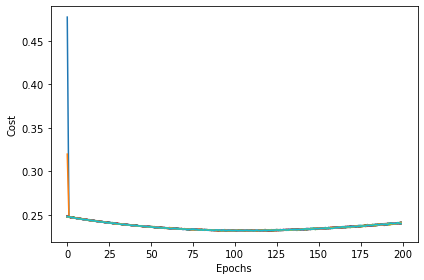

[[0.4772884669628187, 0.31994993451268483, 0.249068454351296, 0.24853987592946744, 0.24838343580832506, 0.2480040471419819, 0.24834566118156642, 0.24828055610884195, 0.2481115444872324, 0.24834405244931346, 0.2483722673188676, 0.24811616960937674, 0.24836053602575775, 0.2482530903811685, 0.2482927424095778, 0.2480756410378638, 0.24834215454557568, 0.24821412262162812, 0.24822466726764258, 0.24805832091189295, 0.2482141236256323, 0.24816662270431508, 0.24813917475877326, 0.2479342402103414, 0.24871485431744103, 0.24831239703340158, 0.2480600989923825, 0.2479225644285272, 0.24807805932333993, 0.24784244359087176, 0.2481902466916124, 0.2479744951975336, 0.2479719657340162, 0.24816768211528306, 0.24793780941302085, 0.24822589271477974, 0.24784813476643736, 0.24826098444739703, 0.2479173468296197, 0.24800457955365549, 0.2479376979774393, 0.24790714094379807, 0.2480899729101387, 0.24786774875350565, 0.2478313271832461, 0.2479996055614472, 0.2478246833042978, 0.2478894348812526, 0.24791594744

In [88]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

## 2 Layer Perceptron with One-Hot Encoding and Normalized


### Graph Loss

## Compare Results for 2 Layer Perceptrons

# Modeling
## 3 Layer
## 4 Layer
## 5 Layer


## 5 Layer Adaptive

# 5 Layer AdaM